In [1]:
using DataFrames, PyPlot, PyCall, FITSTables
#include("fitsdf.jl")
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
;

In [2]:
#df = fitsdf("distributed_topsnr_test.classified.fits", 2);
#df = fitsdf("distributed_topsnr_test.classified.fits", 2);
df = FITS(f->DataFrame(f[2]), "random_30000_test.classified.fits");

In [4]:
df.ismatch = df.isline .& (df.EEW .> 0.1) .& (df.EEW_err .< 0.1/3)
sum(df.ismatch)

1544

In [6]:
using CSV
pleiades = CSV.read("../cats/LAMOST-dr4v2-pleiades-members.csv")
pleiades = Set(pleiades.designation) ;

In [10]:
using FITSIO, FITSTables, DataFrames
lamost = FITS("../cats/LAMOST-dr5v3-designations-coords-gaia.fits") do f
    DataFrame(f[2])
end
;

In [11]:
df = join(df, lamost, on=:designation);

In [17]:
lamost = FITS(DataFrame ∘ last, "../cats/LAMOST-dr5-v3-stellar.fits.gz")[:, [:designation, :obsid]];

In [18]:
df = join(df, lamost, on=:designation);

In [12]:
#odf = join(df[df.ismatch, :], lamost, on=:obsid, kind=:left)
#odf.teff[ismissing.(odf.teff)] .= NaN
#odf.logg[ismissing.(odf.logg)] .= NaN;
#;

In [19]:
include("get_lamost_spectra.jl")
outliers = df[df.ismatch, :obsid]
neighbors = reduce(vcat, df[df.ismatch, :neighbors])
download_lamost_spectra(Set(outliers) ∪ Set(neighbors), verbose=false);

ArgumentError: ArgumentError: column name :neighbors not found in the data frame

In [8]:
reference = Dict()
for obsid in neighbors
    wl, f, ivar = load_lamost_spectrum(obsid)
    reference[obsid] = f
end

In [110]:
residuals = map(eachrow(df[df.ismatch, :])) do row
    F = hcat((n->reference[n]).(row.neighbors)...)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    (flux - F*row.weights) .* sqrt.(ivar)
end
;

In [56]:
spectra = map(eachrow(df[df.ismatch, :])) do row
    F = hcat((n->reference[n]).(row.neighbors)...)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    flux
end
;

In [10]:
include("air_vacuum.jl")

vac_to_air (generic function with 1 method)

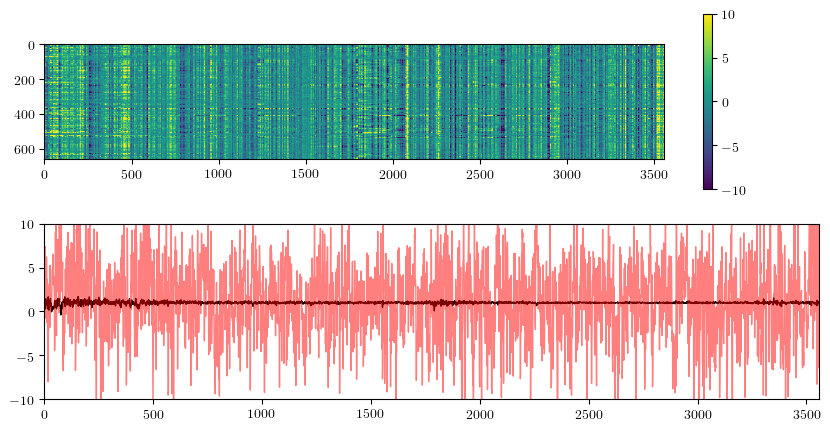

(0.0, 3559.0)

In [141]:
axs = subplots(2, 1, figsize=(10, 5))[2]
sca(axs[1])
imshow(reduce(vcat, transpose.(residuals)), vmin=-10, vmax=10)
colorbar()
sca(axs[2])
plot(rand(reference)[2], lw=1, c="k")
plot(mean(residuals) .+ 1, c="r", lw="1", alpha=0.5)
ylim(-10, 10)
xlim(0, length(residuals[1]))

In [12]:
wl_grid = load("wl_grid.jld2")["wl_grid"];

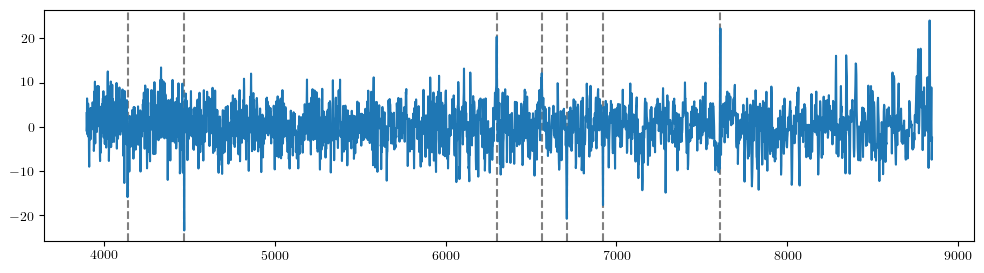

PyObject <matplotlib.lines.Line2D object at 0x139e5ef28>

In [142]:
figure(figsize=(12, 3))
plot(vac_to_air.(wl_grid), mean(residuals))

kwargs = Dict([:c=>"k", :alpha=>0.5, :zorder=>-1, :ls=>"--"])
#axvline(4030.75; kwargs...) #manganese?
axvline(4139; kwargs...) #??? V?

axvline(4470.4; kwargs...) #Ni? 
axvline(6299; kwargs...) #Si I?
axvline(6562.8; kwargs...) #H alpha
axvline(6708; kwargs...) # Li
axvline(7608; kwargs...) #teluric? F? Al?
axvline(6920; kwargs...) #teluric? 

#ylim(-0.08, 0.05)
#xlim(6550, 6600)

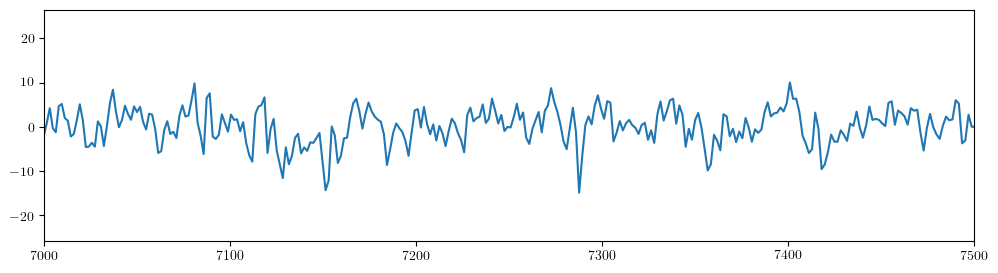

(7000.0, 7500.0)

In [135]:
figure(figsize=(12, 3))
plot(vac_to_air.(wl_grid), mean(residuals))
xlim(7000, 7500)

## investigate Si?

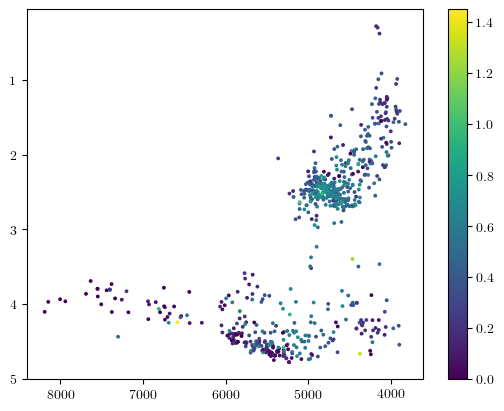

PyObject <matplotlib.colorbar.Colorbar object at 0x11a5af550>

In [53]:
si_mask = 6290 .< vac_to_air.(wl_grid) .< 6305
sidiff = map(residuals) do spec
    sum(spec[si_mask])
end

scatter(odf.teff, odf.logg, c=sidiff, s=3, vmin=0)
gca().invert_xaxis()
gca().invert_yaxis()
colorbar(excess)

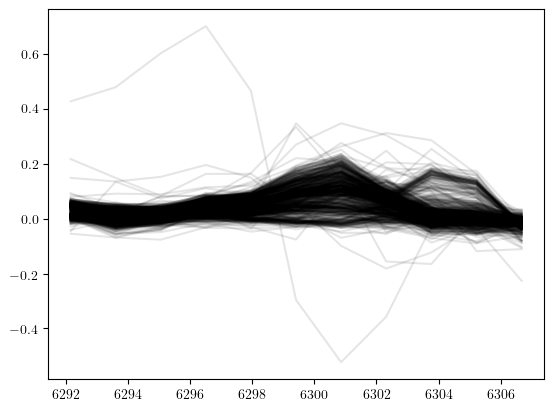

In [55]:
for spec in residuals#[halphadiff .> 0.5, :] 
    plot(wl_grid[si_mask], spec[si_mask], alpha=0.1, c="k")
end

## investigate H alpha

In [60]:
halpha_mask = 6550. .< wl_grid .< 6580
halphadiff = map(residuals) do spec
    sum(spec[halpha_mask])
end
;

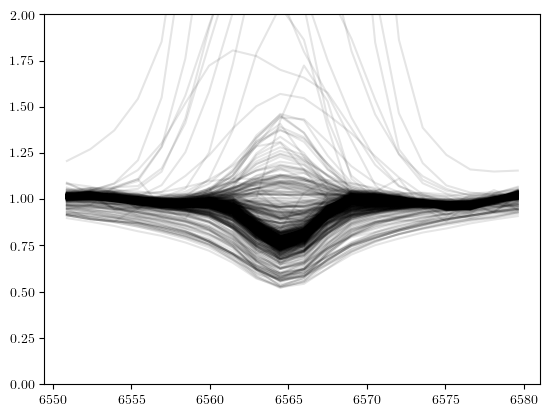

(0.0, 2.0)

In [61]:
for spec in spectra#[halphadiff .> 0.5, :] 
    plot(wl_grid[halpha_mask], spec[halpha_mask], alpha=0.1, c="k")
end
ylim(0, 2)

In [64]:
halpha_emission = map(spectra) do spec
    sum(spec[halpha_mask] .- 1) .> 0
end
;

In [71]:
halpha_weak = (halphadiff .> 0.5) .& (.! halpha_emission);

In [70]:
plt.scatter(odf.teff, odf.logg, c=halphadiff, s=3, vmin=0, vmax = 2)#, norm=LogNorm())
mask = [o in pleiades for o in odf.obsid]
plt.scatter(odf[mask, :teff], odf[mask, :logg], marker="x", c=:r)
gca().invert_xaxis()
gca().invert_yaxis()
colorbar()

UndefVarError: UndefVarError: halpha_emisionr not defined

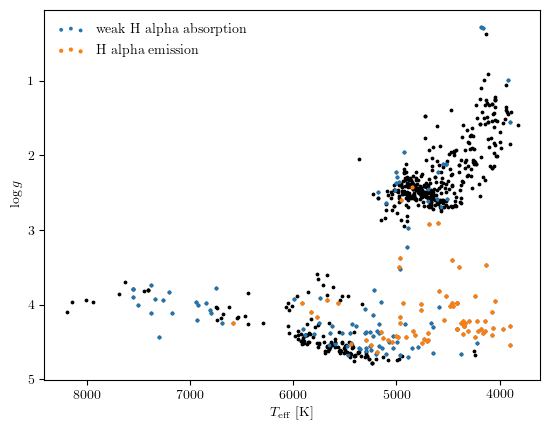

PyObject Text(22.299550986642984, 0.5, '$\\log g$')

In [89]:
scatter(odf.teff, odf.logg, s=3, c="k")
scatter(odf.teff[halpha_weak], odf.logg[halpha_weak], s=3, label="weak H alpha absorption")
scatter(odf.teff[halpha_emission], odf.logg[halpha_emission], s=4, label="H alpha emission")
legend()

gca().invert_xaxis()
gca().invert_yaxis()

setlabs(:teff, :logg)